# Image-Based Detection of Programming Languages

Uses standard image classification models to classify images of source code.

## Setup

Set up Jupyter Notebook, import packages, set some constants.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

from fastai import *
from fastai.vision import *

In [3]:
PATH = 'data/'

bs = 64
model_id = 'model-1'

tfms = []
size = 299


## Load data

In [4]:
def load_images():
    """ Loads images in PATH, sorting them into classes based on the subdirectory name.
    """
    p = Path(PATH)
    files = []
    classes = []
    for subdir in p.ls():
        for fn in subdir.glob('*.png'):
            files.append(fn)
            classes.append(subdir.name)

    return ImageDataBunch.from_lists(PATH, files, classes, ds_tfms=tfms, bs=bs, size=size)

data = load_images()


In [5]:
# Show the classes (categories)
print(len(data.classes), data.classes)


8 ['go', 'python', 'csharp', 'rust', 'java', 'c', 'ruby', 'cpp']


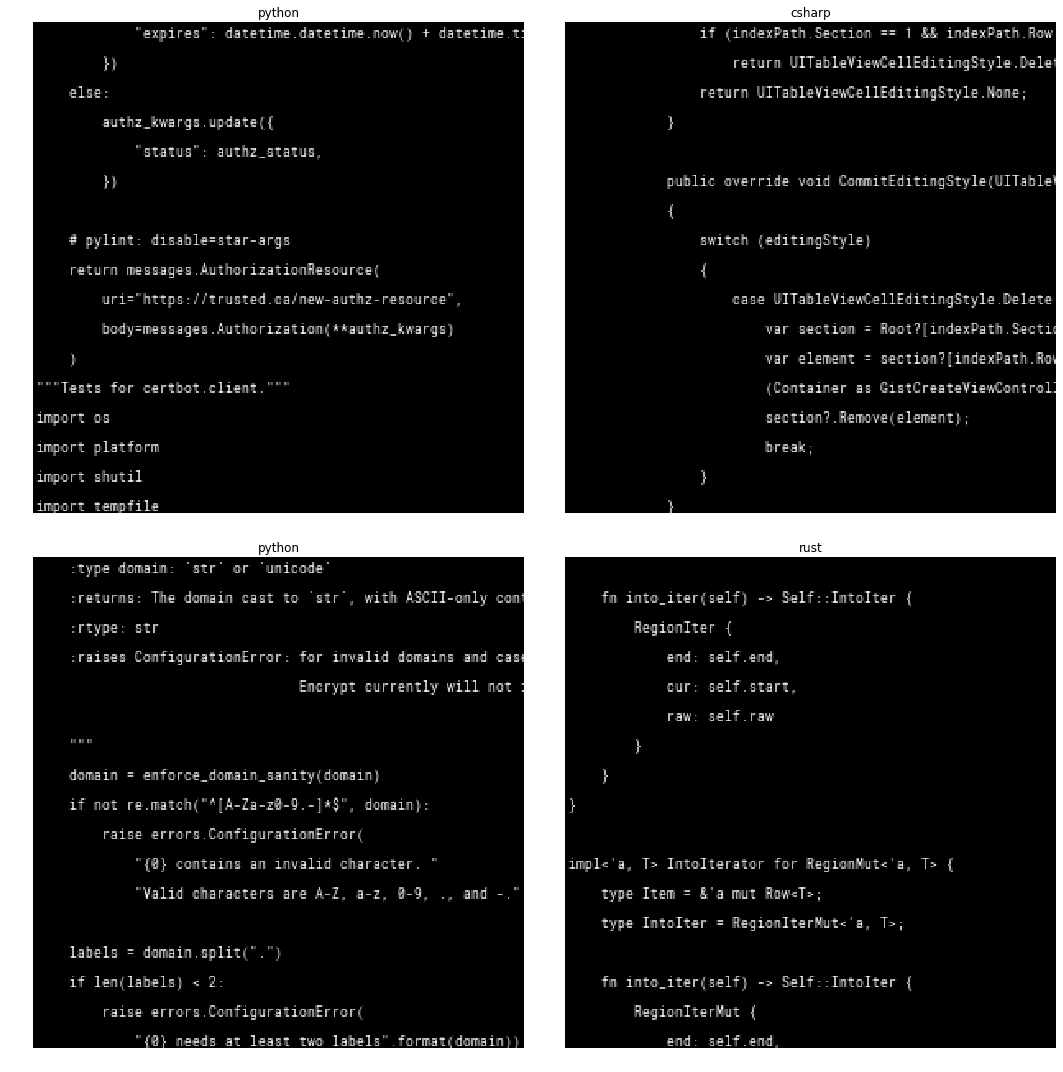

In [6]:
# Show some sample images
data.show_batch(rows=2, figsize=(15, 15))

## Model

Based on ResNet34.

In [7]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### Initial training

Only trains the final layer of the model.

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


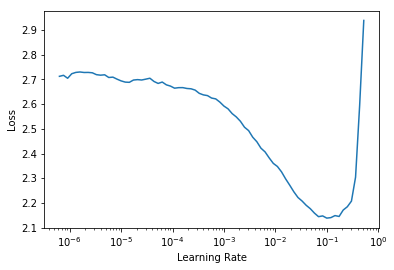

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(6, 2e-2)

Total time: 02:12
epoch  train_loss  valid_loss  error_rate
1      1.394006    2.498471    0.744836    (00:23)
2      0.918935    1.715245    0.415553    (00:21)
3      0.683497    1.291347    0.403402    (00:21)
4      0.475521    0.455791    0.174970    (00:21)
5      0.295698    0.271541    0.078979    (00:22)
6      0.180233    0.227395    0.071689    (00:22)



In [10]:
learn.save(f'{model_id}-stage-1')

### Unfreeze and train the full model

Train the full model (i.e. all layers) with smaller learning rates. This basically fine-tunes the earlier layers to better fit the new task it is given.

In [11]:
learn.load(f'{model_id}-stage-1')
learn.unfreeze()

In [12]:
learn.fit_one_cycle(8, slice(1e-5, 1e-4))

Total time: 03:45
epoch  train_loss  valid_loss  error_rate
1      0.095226    0.220977    0.077764    (00:28)
2      0.079613    0.210287    0.064399    (00:27)
3      0.065561    0.227906    0.069259    (00:28)
4      0.044867    0.221628    0.068044    (00:28)
5      0.030210    0.209533    0.065614    (00:28)
6      0.022746    0.191124    0.059538    (00:28)
7      0.015487    0.183024    0.054678    (00:28)
8      0.012392    0.180203    0.053463    (00:28)



In [13]:
learn.save(f'{model_id}-stage-2')

### Further training of the final layer

Freeze the model again and do further training of the final layer to get maximum accuracy.

In [14]:
learn.load(f'{model_id}-stage-2')
learn.freeze()

In [15]:
learn.fit_one_cycle(5, max_lr=1e-3)

Total time: 01:47
epoch  train_loss  valid_loss  error_rate
1      0.008691    0.181922    0.054678    (00:21)
2      0.007463    0.239170    0.071689    (00:21)
3      0.006695    0.212577    0.055893    (00:21)
4      0.005829    0.204746    0.057108    (00:21)
5      0.004298    0.201159    0.051033    (00:21)



In [16]:
learn.save(f'{model_id}-stage-3')

## Explore the results

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

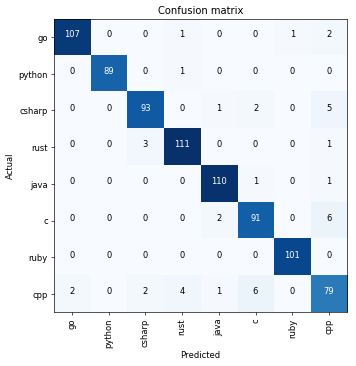

In [18]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

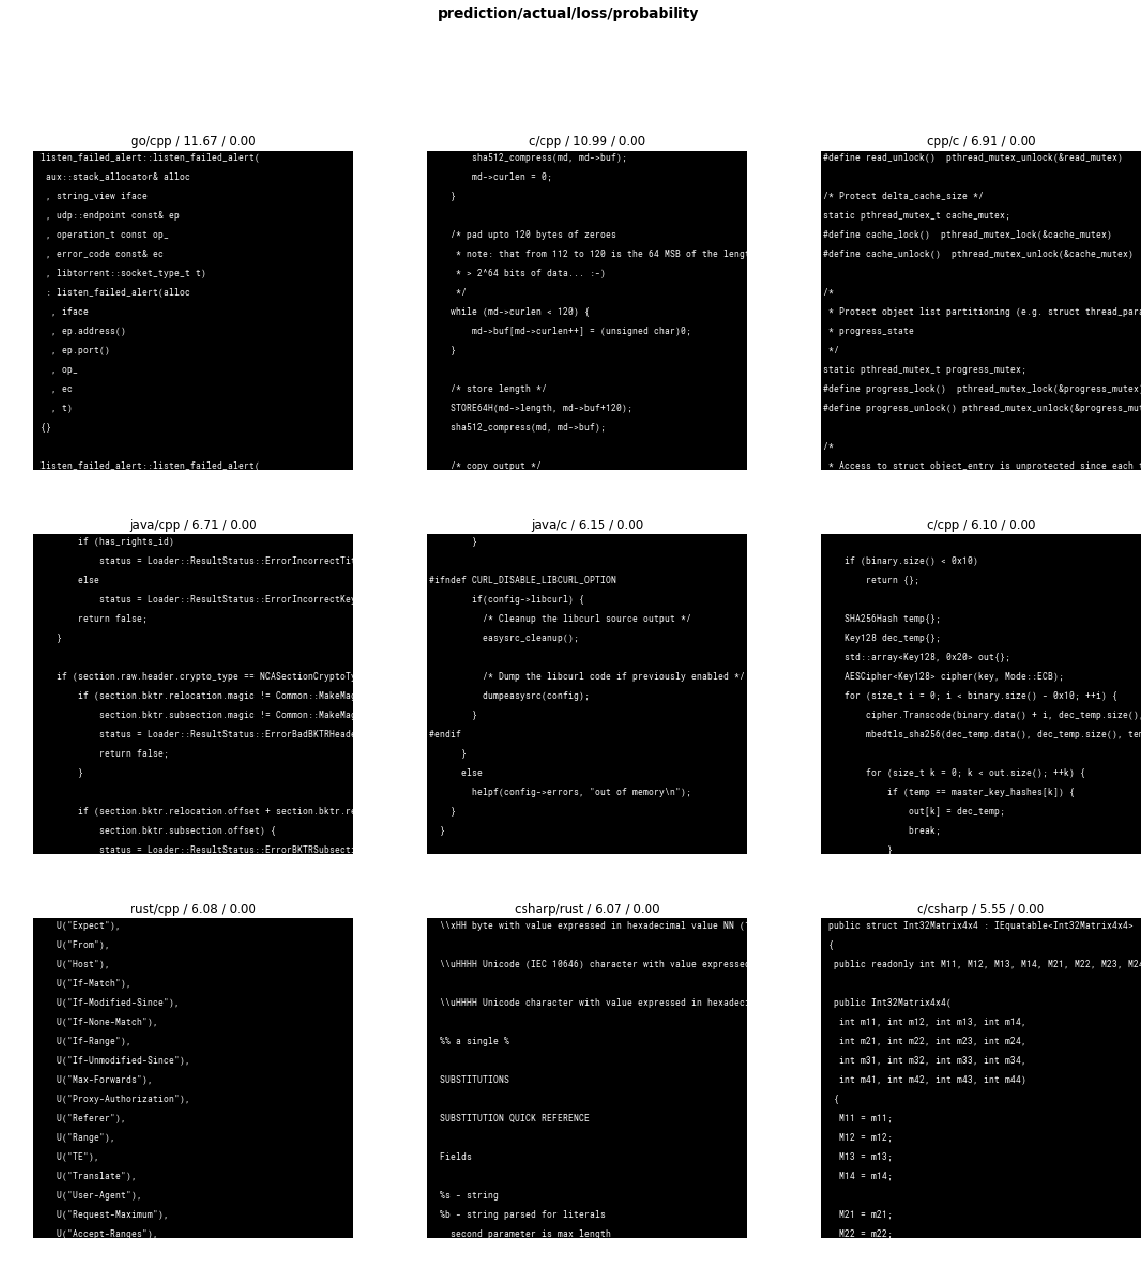

In [19]:
# Let's see the most incorrect predictions
interp.plot_top_losses(9, figsize=(20,20))

In [20]:
# Most confused categories, e.g. first line tells that C code was mistaken to be C++ quite often.
interp.most_confused()

[('c', 'cpp', 6),
 ('cpp', 'c', 6),
 ('csharp', 'cpp', 5),
 ('cpp', 'rust', 4),
 ('rust', 'csharp', 3),
 ('go', 'cpp', 2),
 ('csharp', 'c', 2),
 ('c', 'java', 2),
 ('cpp', 'go', 2),
 ('cpp', 'csharp', 2)]

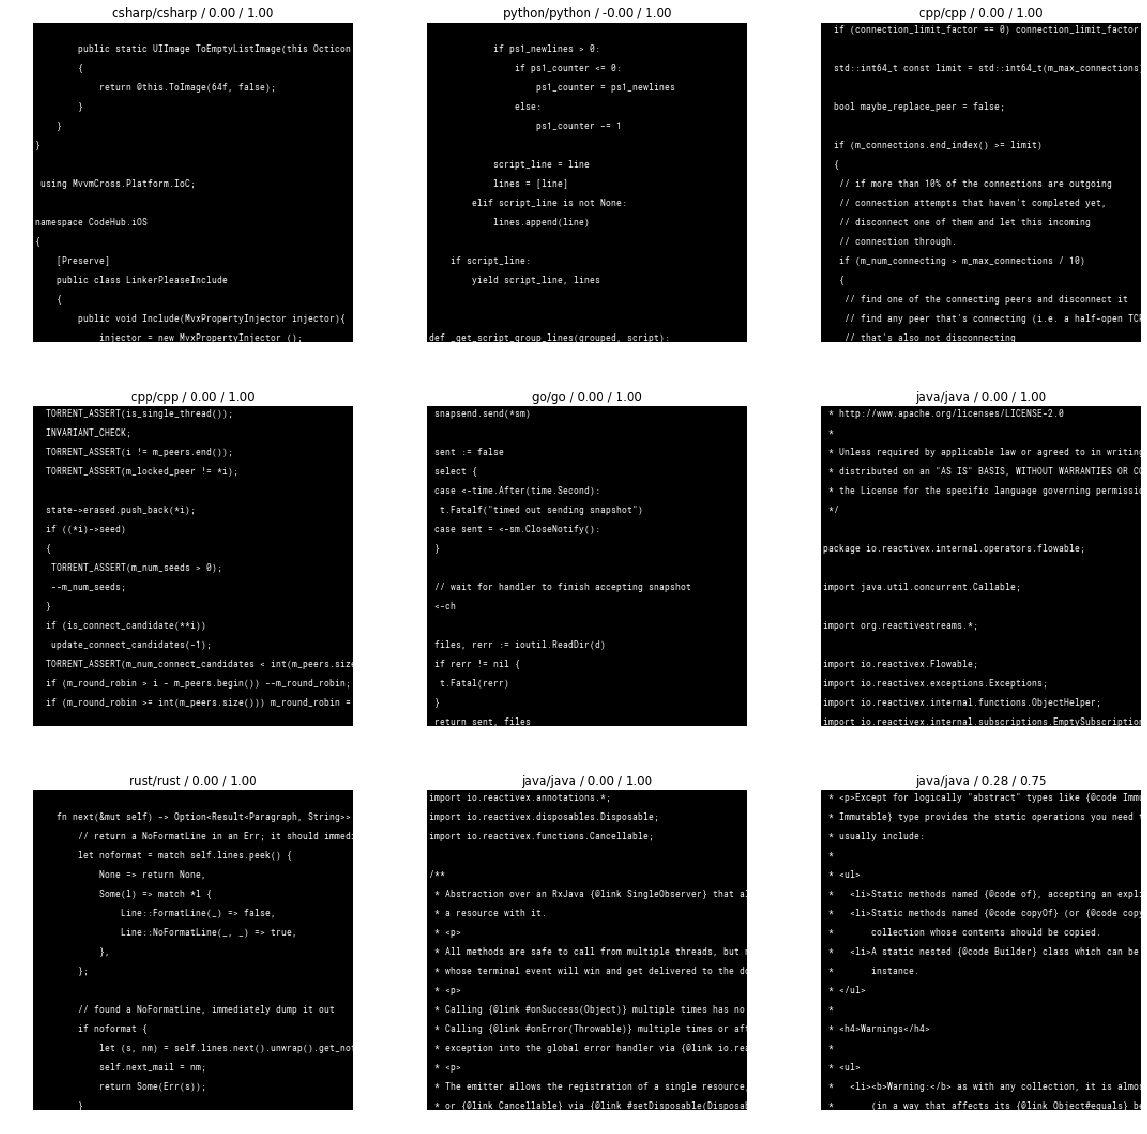

In [21]:
# Plot a few random predictions
def plot_random_predictions(interp, k, figsize=(12,12)):
    classes = interp.data.classes
    preds_count = len(interp.pred_class)
    sample_idxs = random.sample(range(preds_count), k)

    rows = math.ceil(math.sqrt(k))
    fig,axes = plt.subplots(rows,rows,figsize=figsize)
    #fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
    
    for i, idx in enumerate(sample_idxs):
        t = interp.data.valid_ds[idx]
        title = f'{classes[interp.pred_class[idx]]}/{classes[t[1]]} / {interp.losses[idx]:.2f} / {interp.probs[idx][t[1]]:.2f}'
        t[0].show(ax=axes.flat[i], title=title)

plot_random_predictions(interp, 9, figsize=(20, 20))